In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__


import magrec.image_processing.Masks as Masks
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

Applied a high frequency filter, removing all components smaller than 0.5 um


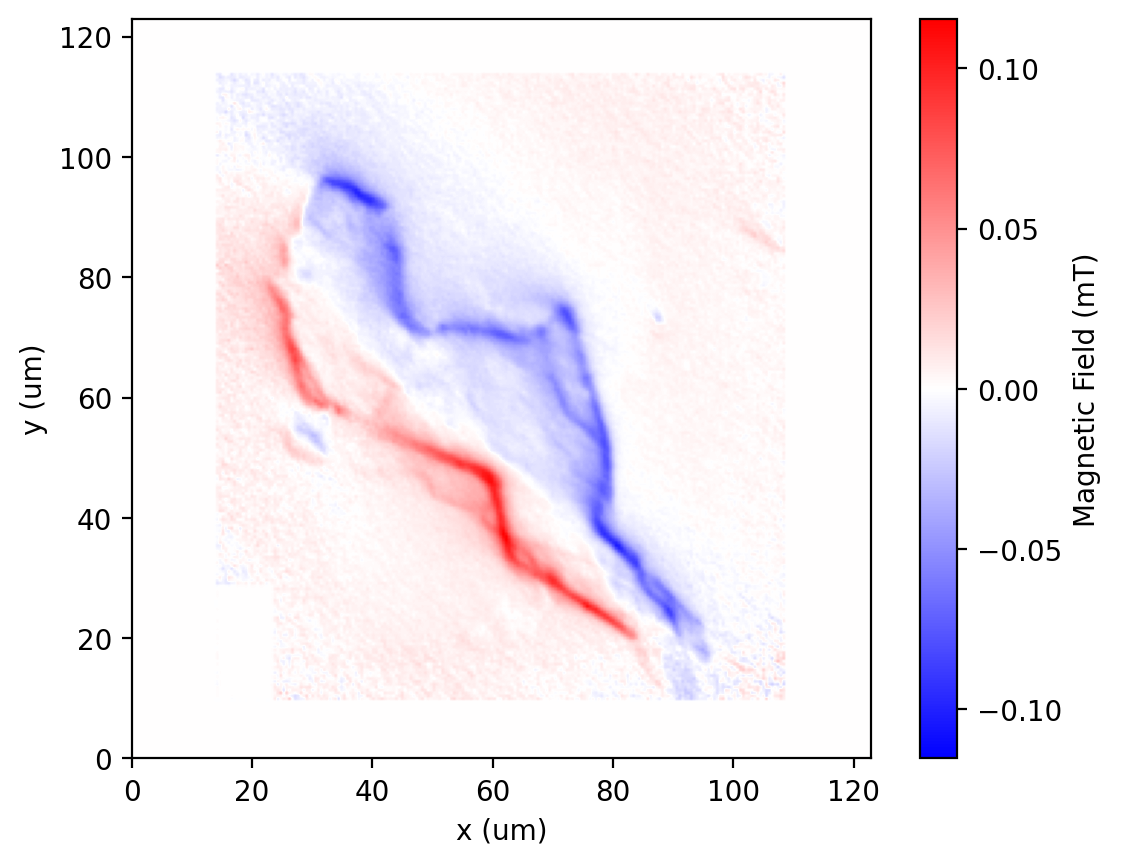

In [4]:
f = open(__datapath__ / "Mxy" / "CuCrP2S6_unimelb_measurement_72_Bnv.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
Bz = np.array(data["ExperimentMagneticField"]['Bz'])
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6


Bz[-40:-1,0:20] = 0
Bz[-1,0:20] = 0

sensor_theta = 0
sensor_phi = 0

height = 0.1
thickness = 0

dataset = Data()
dataset.load_data(-1*Bz, dx, dy, height, sensor_theta, sensor_phi, thickness)

dataset.remove_DC_background()
# Add filter 
dataset.add_hanning_filter(0.5)
dataset.add_short_wavelength_filter(0.5)
dataset.pad_data_to_power_of_two()

dataset.plot_target()

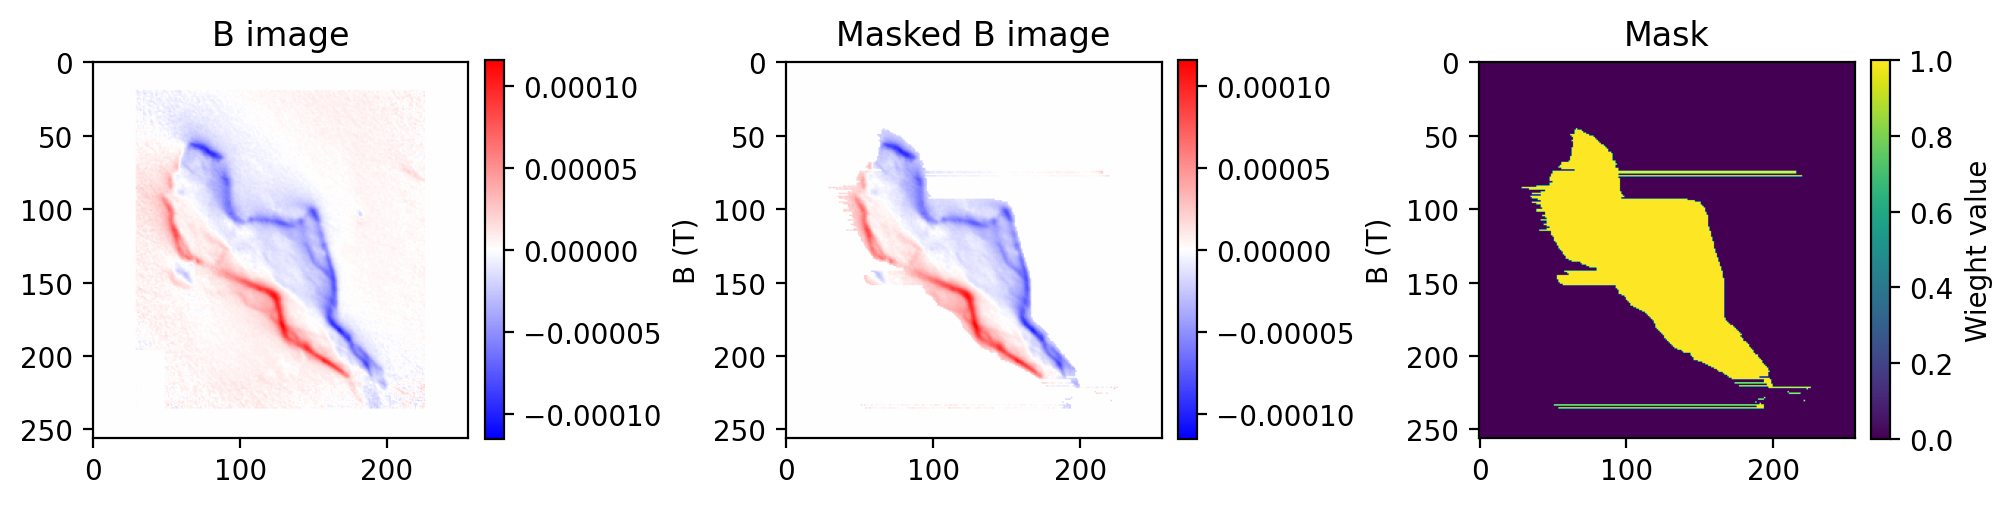

In [6]:
source_wieght = Masks.mask_hor_dir(dataset.target, 2e-5, plot=True)

# m_phi = 46 -90 + 180

Model = UniformMagnetisation(dataset, "MSE", 
                             m_theta = 85, 
                             m_phi = 226-90,
                             positive_magnetisation = True,
                             fit_m_theta = False, 
                             fit_m_phi = True,
                             scaling_factor = 1e9, 
                             std_loss_scaling = 0, 
                             loss_weight = None,
                             source_weight = source_wieght,
                             spatial_filter = False,
                             spatial_filter_width = 0.1)

# Model.plot_weights()


## Now we will try to reconstruct the magnetisation using a neural network.

Number of sources: 1
Number of targets: 1
Including source angles in the neural network: True
epoch     1 | loss on last mini-batch:  2.14e+08
epoch    26 | loss on last mini-batch:  2.14e+08
epoch    51 | loss on last mini-batch:  2.12e+08
epoch    76 | loss on last mini-batch:  1.69e+08
epoch   101 | loss on last mini-batch:  5.28e+07
epoch   126 | loss on last mini-batch:  4.21e+07
epoch   151 | loss on last mini-batch:  4.02e+07
epoch   176 | loss on last mini-batch:  3.99e+07
epoch   201 | loss on last mini-batch:  3.97e+07
epoch   226 | loss on last mini-batch:  3.97e+07
epoch   251 | loss on last mini-batch:  3.97e+07
epoch   276 | loss on last mini-batch:  3.97e+07


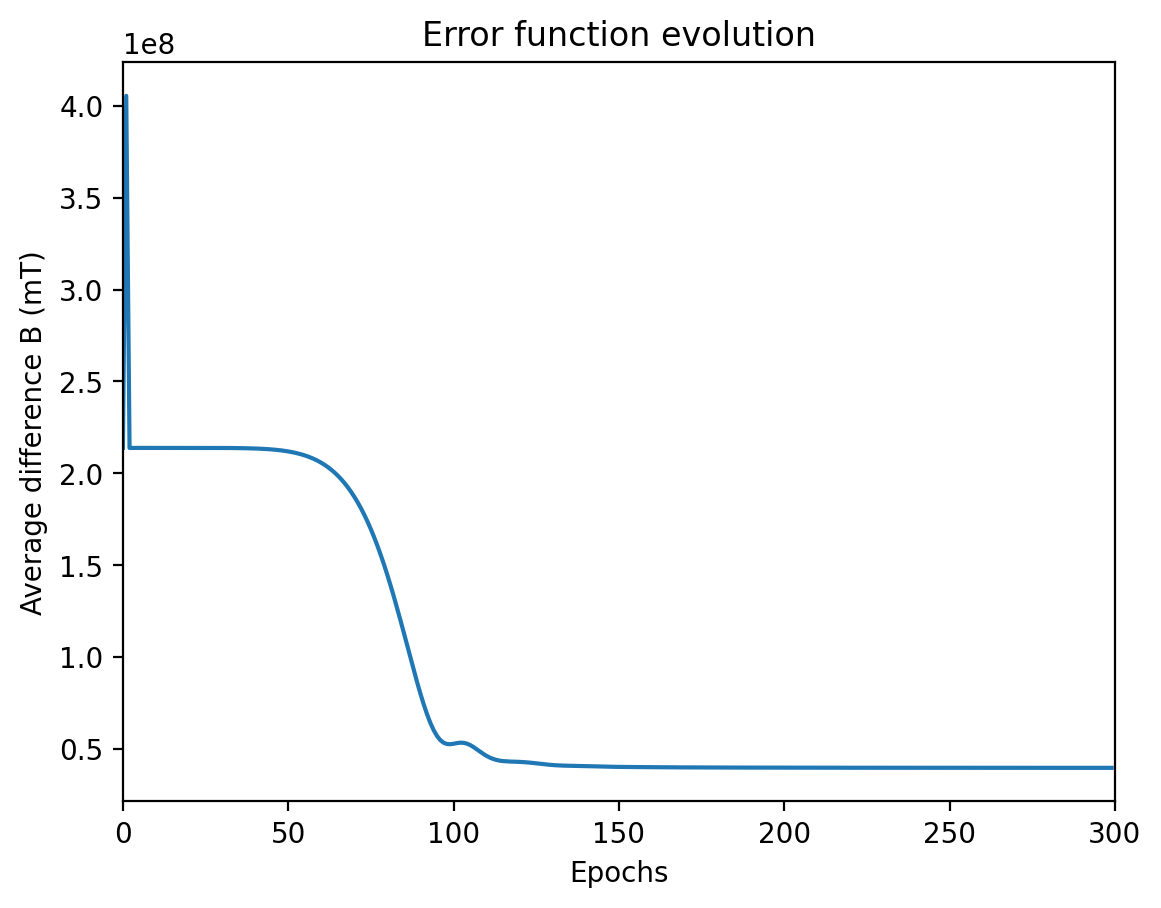

In [7]:
FittingMethod = FCNN(Model)
FittingMethod.fit(n_epochs=300)
FittingMethod.plot_loss()

The value of the magnetisation based off previous results should be: 
 
theta: 85.00

phi: 226.00

Final reconstruction from the network used the following angles:
theta: 85.00
phi: 217.74


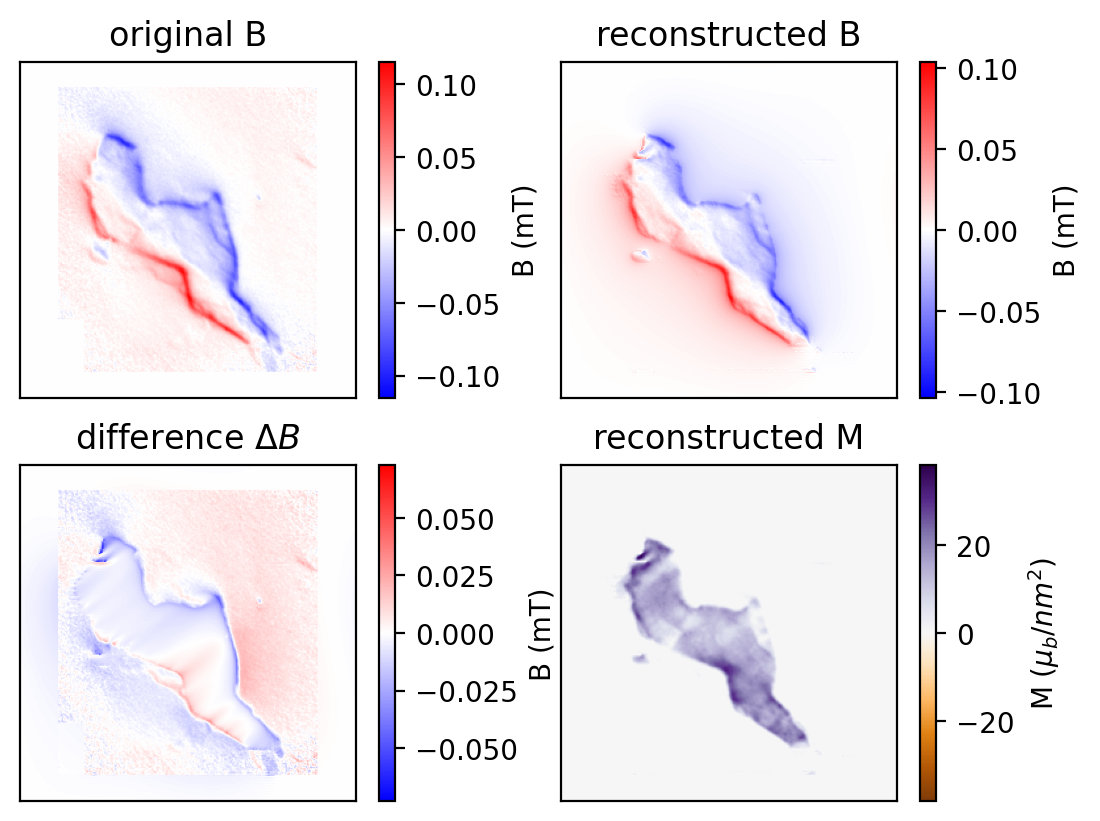

In [8]:
FittingMethod.extract_results(remove_padding=False)
FittingMethod.plot_results()
